In [1]:
import pandas as pd
from tqdm.autonotebook import tqdm
tqdm.pandas()

import ast

from nltk import FreqDist

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Import Data

In [2]:
df = pd.read_csv('data/styles_with_token.csv')

In [35]:
df.head()

,id,masterCategory,subCategory,articleType,baseColour,title,tokenized,file_name
0,1163,Apparel,Topwear,Tshirts,Blue,Nike Sahara Team India Fanwear Round Neck Jersey,"['<start>', 'nike', 'sahara', 'team', 'india',...",1163.jpg
1,1164,Apparel,Topwear,Tshirts,Blue,Nike Men Blue T20 Indian Cricket Jersey,"['<start>', 'nike', 'men', 'blue', 'indian', '...",1164.jpg
2,1165,Apparel,Topwear,Tshirts,Blue,Nike Mean Team India Cricket Jersey,"['<start>', 'nike', 'mean', 'team', 'india', '...",1165.jpg
3,1525,Accessories,Bags,Backpacks,Navy Blue,Puma Deck Navy Blue Backpack,"['<start>', 'puma', 'deck', 'navy', 'blue', 'b...",1525.jpg
4,1526,Accessories,Bags,Backpacks,Black,Puma Big Cat Backpack Black,"['<start>', 'puma', 'big', 'cat', 'backpack', ...",1526.jpg


In [36]:
# convert tokens from stringified list back to list
df.tokenized = df.tokenized.apply(lambda tokens: ast.literal_eval(tokens))

## Tag Products

Tag all of products using most common 1000 words from products' title

### Get Tag List

In [37]:
tokens_frequency = FreqDist()
for tokens in df.tokenized:
    tokens_frequency += FreqDist(tokens)

In [38]:
len(tokens_frequency)

7244

In [39]:
tokens_frequency.most_common(5)

[('<start>', 44441),
 ('<end>', 44441),
 ('men', 21631),
 ('women', 15220),
 ('black', 9673)]

In [40]:
tag_list = tokens_frequency.most_common(1002)
tag_list = [tag for tag, freq in tag_list]

In [41]:
# remove '<start>' and '<end>'
tag_list = tag_list[2:]

In [42]:
len(tag_list)

1000

### Save Tag List

In [43]:
df_tag_list = pd.DataFrame({
    'tags': tag_list,
    'tags_a-z': sorted(tag_list),
})

In [44]:
df_tag_list.head()

,tags,tags_a-z
0,men,absolute
1,women,acc
2,black,accessories
3,blue,accessory
4,white,active


In [45]:
df_tag_list.to_csv("data/tag_list.csv", index=False)

### Tag Products

In [46]:
products_tags = []
def tag_product(tokens):
    tags = []
    for token in tokens:
        if token in tag_list:
            tags.append(token)
    
    products_tags.append(tags)

_ = df['tokenized'].progress_apply(tag_product)

In [47]:
products_tags[:5]

[['nike', 'team', 'india', 'round', 'neck', 'jersey'],
 ['nike', 'men', 'blue', 'indian', 'cricket', 'jersey'],
 ['nike', 'team', 'india', 'cricket', 'jersey'],
 ['puma', 'navy', 'blue', 'backpack'],
 ['puma', 'big', 'cat', 'backpack', 'black']]

In [48]:
df['tags'] = pd.Series(products_tags)

In [49]:
df.head()

,id,masterCategory,subCategory,articleType,baseColour,title,tokenized,file_name,tags
0,1163,Apparel,Topwear,Tshirts,Blue,Nike Sahara Team India Fanwear Round Neck Jersey,"[<start>, nike, sahara, team, india, fanwear, ...",1163.jpg,"[nike, team, india, round, neck, jersey]"
1,1164,Apparel,Topwear,Tshirts,Blue,Nike Men Blue T20 Indian Cricket Jersey,"[<start>, nike, men, blue, indian, cricket, je...",1164.jpg,"[nike, men, blue, indian, cricket, jersey]"
2,1165,Apparel,Topwear,Tshirts,Blue,Nike Mean Team India Cricket Jersey,"[<start>, nike, mean, team, india, cricket, je...",1165.jpg,"[nike, team, india, cricket, jersey]"
3,1525,Accessories,Bags,Backpacks,Navy Blue,Puma Deck Navy Blue Backpack,"[<start>, puma, deck, navy, blue, backpack, <e...",1525.jpg,"[puma, navy, blue, backpack]"
4,1526,Accessories,Bags,Backpacks,Black,Puma Big Cat Backpack Black,"[<start>, puma, big, cat, backpack, black, <end>]",1526.jpg,"[puma, big, cat, backpack, black]"


### Remove Products with No Tags

In [50]:
df['tags'] = df['tags'].apply(str)

In [64]:
len(df[df['tags'] == '[]'])

10

In [65]:
df = df[df['tags'] != '[]']

In [66]:
len(df)

44431

### Save Products with Tags

In [67]:
df.to_csv('data/styles_tagged.csv', index=False)

## Create Image Tagger Model

In [1]:
import ast
import os
import copy
import time

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
from torchvision import transforms
from torchsummary import summary
import pkbar

from PIL import Image

import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
tqdm.pandas()

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
from skimage import io
from sklearn.metrics import hamming_loss, accuracy_score

import matplotlib.pyplot as plt
plt.ion()   # interactive mode

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
np.random.seed(105)

In [3]:
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using CUDA


### Import Data

#### Products' Data

In [4]:
df = pd.read_csv('data/styles_tagged.csv')

In [5]:
df.head()

,id,masterCategory,subCategory,articleType,baseColour,title,tokenized,file_name,tags
0,1163,Apparel,Topwear,Tshirts,Blue,Nike Sahara Team India Fanwear Round Neck Jersey,"['<start>', 'nike', 'sahara', 'team', 'india',...",1163.jpg,"['nike', 'team', 'india', 'round', 'neck', 'je..."
1,1164,Apparel,Topwear,Tshirts,Blue,Nike Men Blue T20 Indian Cricket Jersey,"['<start>', 'nike', 'men', 'blue', 'indian', '...",1164.jpg,"['nike', 'men', 'blue', 'indian', 'cricket', '..."
2,1165,Apparel,Topwear,Tshirts,Blue,Nike Mean Team India Cricket Jersey,"['<start>', 'nike', 'mean', 'team', 'india', '...",1165.jpg,"['nike', 'team', 'india', 'cricket', 'jersey']"
3,1525,Accessories,Bags,Backpacks,Navy Blue,Puma Deck Navy Blue Backpack,"['<start>', 'puma', 'deck', 'navy', 'blue', 'b...",1525.jpg,"['puma', 'navy', 'blue', 'backpack']"
4,1526,Accessories,Bags,Backpacks,Black,Puma Big Cat Backpack Black,"['<start>', 'puma', 'big', 'cat', 'backpack', ...",1526.jpg,"['puma', 'big', 'cat', 'backpack', 'black']"


In [6]:
# convert stringified-list-type columns back to list
df.tokenized = df.tokenized.apply(lambda tokens: ast.literal_eval(tokens))
df.tags = df.tags.apply(lambda tags: ast.literal_eval(tags))

In [7]:
removed_master_category = [
    "Home",
    "Sporting Goods",
    "Free Items"
]

df = df[~df.masterCategory.isin(removed_master_category)]

In [8]:
len(df)

44300

#### Tag List

In [9]:
df_tag_list = pd.read_csv("data/tag_list.csv")

In [10]:
df_tag_list.head()

,tags,tags_a-z
0,men,absolute
1,women,acc
2,black,accessories
3,blue,accessory
4,white,active


### Create Model using PyTorch

The model is created with ResNet-152

In [11]:
class ImageTagger(nn.Module):
    r"""Tagger Encoder extends ResNet152 Model.

    Arguments:
        semantic_size (int, optional): size of semantic size
        dropout (float, optional): dropout rate
    """

    def __init__(self, semantic_size=1000, dropout=0.15):
        super(ImageTagger, self).__init__()
        self.semantic_size = semantic_size

        # Using pre-trained ImageNet
        resnet = torchvision.models.resnet152(pretrained=True)

        # Remove linear layers (since we're not doing classification)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        self.dropout = nn.Dropout(dropout)

        self.linear = nn.Linear(2048, semantic_size)

        self.sigmoid = nn.Sigmoid()

        self.fine_tune()

    def forward(self, images):
        r"""Forward propagation.

        Arguments
            images (torch.Tensor): images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        Returns 
            torch.Tensor: probabilites of tags (batch_size, 1000)
        """
        out = self.resnet(images)
        out = out.view(out.size(0), -1)   # (batch_size, 2048)
        out = self.dropout(out)           # (batch_size, 2048)
        out = self.linear(out)            # (batch_size, 1000)
        out = self.sigmoid(out)           # (batch_size, 1000)
        
        return out

    def fine_tune(self, fine_tune=True):
        r"""Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.

        Arguments
            fine_tune (boolean): Allow fine tuning?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

In [12]:
# image_tagger = ImageTagger()
# image_tagger = image_tagger.cuda()

In [13]:
# summary(image_tagger, input_size=(3, 224, 224))

### One-hot Product Tags

In [14]:
product_tags = df['tags']

In [15]:
mlb = MultiLabelBinarizer()

df_one_hot_tags = pd.DataFrame(mlb.fit_transform(product_tags),columns=mlb.classes_, index=df.index)

In [16]:
df_one_hot_tags.head()

,absolute,acc,accessories,accessory,active,ad,adh,adi,adidas,adrika,...,yelloe,yellow,yo,yoga,york,you,youth,zip,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
product_tags = df_one_hot_tags.values

In [18]:
product_tags

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Data Preparation

#### Torch Dataset Class 

In [19]:
class ProductTagsDataset(Dataset):
    """Product and its tags dataset."""

    def __init__(self, file_names, product_tags, image_dir, transformer=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.product_tags = product_tags
        self.file_names = file_names
        self.image_dir = image_dir
        self.transformer = transformer

    def __len__(self):
        return len(self.product_tags)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.file_names[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transformer:
            image = self.transformer(image)
        
        tags = self.product_tags[idx]
        tags = torch.tensor(tags, dtype=torch.float)
     
        sample = {'image': image, 'tags': tags}

        return sample

In [20]:
file_names = df['file_name'].values

0 (224, 298) torch.Size([1000])
1 (224, 298) torch.Size([1000])
2 (224, 298) torch.Size([1000])
3 (224, 298) torch.Size([1000])


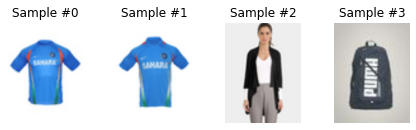

In [23]:
# test data generator
image_transformer = transforms.Compose([
    transforms.Resize(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomResizedCrop(224, scale=(1.0, 1.0)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ProductTagsDataset(file_names, product_tags, "data/images", image_transformer)

fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['image'].size, sample['tags'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

#### Image Augmentation

In [22]:
image_transformer = transforms.Compose([
    transforms.Resize(224),
#     transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Split Train Test 

In [25]:
splitter = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=105)

In [26]:
for train_index, test_index in splitter.split(file_names, product_tags):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = file_names[train_index], file_names[test_index]
    y_train, y_test = product_tags[train_index], product_tags[test_index]

TRAIN: 35429 TEST: 8871


In [27]:
df_y_train = pd.DataFrame(y_train, columns=df_tag_list['tags_a-z'].values)

df_y_train_count = df_y_train.replace({0: np.nan}).count()

df_y_test = pd.DataFrame(y_test, columns=df_tag_list['tags_a-z'].values)

df_y_test_count = df_y_test.replace({0: np.nan}).count()

In [27]:
idx = 20
tag = df_tag_list['tags'][idx]
tag = 'nike'
print(tag)
print(df_y_train_count[tag])
print(df_y_test_count[tag])

nike
1828
457


### Training

In [28]:
def train_model(model, criterion, optimizer, train_dataset, val_dataset, batch_size, num_epochs, scheduler=None, current_epoch=0):
    
    since = time.time()

    # data loader for batched image loading
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)    
    
    best_acc = 0.0
    best_loss = 99999
    best_hamming_loss = 1
    
    # save loss and accuracy history
    loss_history = {
        'train': [],
        'val': [],
    }
    acc_history = {
        'train': [],
        'val': [],
    }
    hamming_loss_history = {
        'train': [],
        'val': [],
    }
    
    for epoch in range(current_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        kbar = pkbar.Kbar(target=len(train_data_loader), width=32)
        
        epoch_loss = {}
        epoch_acc = {}
        epoch_hamming_loss = {}

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_data_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_data_loader

            running_loss = 0
            running_acc = 0
            running_hamming_loss = 0

            # Iterate over data.
            for i, sample in enumerate(data_loader):
                inputs = sample['image'].to(device)
                labels = sample['tags'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = outputs
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                preds_rounded = torch.round(preds).to("cpu").tolist()
                this_acc = sum([pred == label for pred, label in zip(preds_rounded, labels.to("cpu").tolist())])
                running_acc += this_acc
                this_hamming_loss = sum([hamming_loss(pred, label) for pred, label in zip(preds_rounded, labels.to("cpu"))])
                running_hamming_loss += this_hamming_loss
                
                if phase == 'train':
                    kbar.update(i, values=[
                        ("loss", loss), 
                        ("subset_acc", this_acc/batch_size), 
                        ("hamming_loss", this_hamming_loss/batch_size)
                    ])

            epoch_loss[phase] = running_loss / len(data_loader.dataset)
            epoch_acc[phase] = running_acc / len(data_loader.dataset)
            epoch_hamming_loss[phase] = running_hamming_loss / len(data_loader.dataset)
            
            if phase == 'train' and scheduler:
                scheduler.step(epoch_hamming_loss[phase])
            
            loss_history[phase].append(epoch_loss[phase])
            acc_history[phase].append(epoch_acc[phase])
            hamming_loss_history[phase].append(epoch_hamming_loss[phase])

            if phase == 'val' and epoch_acc[phase] > best_acc:
                best_acc = epoch_acc[phase]
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict()
                }, "models/image_tagger.best_acc")
            if phase == 'val' and epoch_loss[phase] < best_loss:
                best_loss = epoch_loss[phase]
            if phase == 'val' and epoch_hamming_loss[phase] < best_loss:
                best_hamming_loss = epoch_hamming_loss[phase]
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict()
                }, "models/image_tagger.best_hamming")
            
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, "models/image_tagger.epoch_" + str(epoch))

        kbar.add(1, values=[("loss", epoch_loss['train']), ("subset_acc", epoch_acc['train']), ("hamming_loss", epoch_hamming_loss['train']), 
                            ("val_loss", epoch_loss['val']), ("val_subset_acc", epoch_acc['val']), ("val_hamming_loss", epoch_hamming_loss['val'])])

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val hamming loss: {:4f}'.format(best_hamming_loss))

    return model, loss_history, acc_history, hamming_loss_history

In [29]:
train_dataset = ProductTagsDataset(X_train, y_train, "data/images", transformer=image_transformer)
test_dataset = ProductTagsDataset(X_test, y_test, "data/images", transformer=image_transformer)

In [33]:
image_tagger = ImageTagger(dropout=0.5)
image_tagger = image_tagger.cuda()

In [34]:
batch_size = 32
epochs = 10
lr = 1e-3

# model = ImageTagger(dropout=0.15)
model = image_tagger.to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, image_tagger.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [146]:
# load model
checkpoint = torch.load("models/image_tagger.epoch_2")
model.load_state_dict(checkpoint['model_state_dict'])
current_epoch = checkpoint['epoch']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [35]:
loss_histories = {
    'train': [],
    'val': [],
}
acc_histories = {
    'train': [],
    'val': [],
}
hamming_loss_histories = {
    'train': [],
    'val': [],
}

In [41]:
model, loss_history, acc_history, hamming_loss_history = train_model(
    model, 
    criterion, 
    optimizer, 
    train_dataset, 
    test_dataset, 
    batch_size, 
    epochs,
    scheduler,
    0
)

for phase in ['train', 'val']:
    loss_histories[phase] += loss_history[phase]
    acc_histories[phase] += acc_history[phase]
    hamming_loss_histories[phase] += hamming_loss_history[phase]

Epoch 1/10
1108/1108 [================================] - 941s 849ms/step - loss: 0.0023 - subset_acc: 0.5047 - hamming_loss: 7.9497e-04 - val_loss: 0.0139 - val_subset_acc: 0.1082 - val_hamming_loss: 0.0030
Epoch 2/10
1108/1108 [================================] - 943s 851ms/step - loss: 0.0021 - subset_acc: 0.5275 - hamming_loss: 7.3865e-04 - val_loss: 0.0139 - val_subset_acc: 0.1140 - val_hamming_loss: 0.0030
Epoch 3/10
1108/1108 [================================] - 938s 847ms/step - loss: 0.0020 - subset_acc: 0.5446 - hamming_loss: 7.0026e-04 - val_loss: 0.0142 - val_subset_acc: 0.1115 - val_hamming_loss: 0.0029
Epoch 4/10
1108/1108 [================================] - 946s 854ms/step - loss: 0.0018 - subset_acc: 0.5688 - hamming_loss: 6.4631e-04 - val_loss: 0.0149 - val_subset_acc: 0.1168 - val_hamming_loss: 0.0029
Epoch 5/10
1108/1108 [================================] - 937s 846ms/step - loss: 0.0017 - subset_acc: 0.5933 - hamming_loss: 5.9869e-04 - val_loss: 0.0155 - val_subset

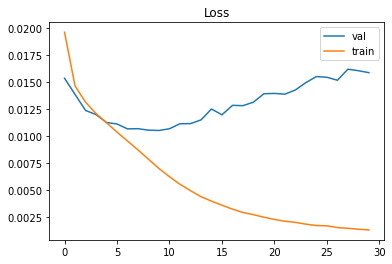

In [ ]:
plt.title("Loss")
plt.plot(loss_histories['val'], label='val')
plt.plot(loss_histories['train'], label='train')

plt.legend()
plt.show()

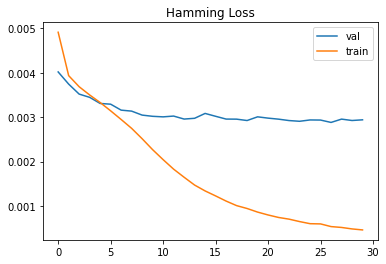

In [ ]:
plt.title("Hamming Loss")
plt.plot(hamming_loss_histories['val'], label='val')
plt.plot(hamming_loss_histories['train'], label='train')

plt.legend()
plt.show()

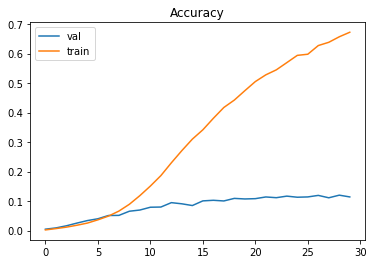

In [ ]:
plt.title("Accuracy")
plt.plot(acc_histories['val'], label='val')
plt.plot(acc_histories['train'], label='train')

plt.legend()
plt.show()

### Check Result

In [152]:
all_image_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224, scale=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [153]:
all_dataset = ProductTagsDataset(file_names, product_tags, "data/images", transformer=all_image_transformer)

In [56]:
# load model
model.load_state_dict(torch.load(model_path_best_acc + model_path_spec))

<All keys matched successfully>

In [154]:
sorted_tags = df_tag_list['tags_a-z']

In [155]:
all_data_loader = DataLoader(all_dataset, batch_size=128, shuffle=False, num_workers=0)    

preds_rounded_all = []
labels_all = []

for i, sample in enumerate(all_data_loader):
    inputs = sample['image'].to(device)
    labels = sample['tags'].to(device)
    labels_all += labels
    
    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        preds = outputs
        preds_rounded_all += [[1 if p >= 0.5 else 0 for p in pred] for pred in preds]
        
    break

#### Save Result

In [ ]:
df = df.drop("Unnamed: 0", axis=1)

In [156]:
preds_decoded = []
labels_decoded = []

for i in range(96):
    pred_series = pd.Series(preds_rounded_all[i])
    preds_decoded.append(list(pred_series[pred_series == 1].index))
    
    label_series = pd.Series(labels_all[i].to("cpu"))
    labels_decoded.append(list(label_series[label_series == 1].index))

In [157]:
preds_val = []
labels_val = []

for pred, label in zip(preds_decoded, labels_decoded):
    preds_val.append(list(map(sorted_tags.__getitem__, pred)))
    labels_val.append(list(map(sorted_tags.__getitem__, label)))

In [158]:
pd.DataFrame({
    'predict': preds_val,
    'label': labels_val,
})

,predict,label
0,"[jersey, neck, nike, red, round, team]","[india, jersey, neck, nike, round, team]"
1,"[blue, jersey, men, nike]","[blue, cricket, indian, jersey, men, nike]"
2,"[men, nike]","[cricket, india, jersey, nike, team]"
3,"[backpack, blue, navy, unisex]","[backpack, blue, navy, puma]"
4,"[backpack, black, cat, logo, puma]","[backpack, big, black, cat, puma]"
...,...,...
91,"[football, kipsta]","[football, kipsta]"
92,"[basketball, kipsta]","[basketball, kipsta]"
93,[shoes],"[shoes, water]"
94,"[newfeel, red, shoes, unisex]","[newfeel, red, shoes, unisex]"


### Predict All and Save

In [159]:
all_data_loader = DataLoader(all_dataset, batch_size=128, shuffle=False, num_workers=0)    

preds_all = []
labels_all = []

for i, sample in enumerate(all_data_loader):
    inputs = sample['image'].to(device)
    labels = sample['tags'].to(device)
    labels_all += labels
    
    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        preds_all += outputs

In [160]:
len(preds_all)

44431

In [161]:
preds_list = [list(pred.cpu().numpy()) for pred in preds_all]

#### Save Result

In [162]:
df["tags_pred"] = preds_list

In [163]:
df.head()

,id,masterCategory,subCategory,articleType,baseColour,title,tokenized,file_name,tags,token_pred
0,1163,Apparel,Topwear,Tshirts,Blue,Nike Sahara Team India Fanwear Round Neck Jersey,"[<start>, nike, sahara, team, india, fanwear, ...",1163.jpg,"[nike, team, india, round, neck, jersey]","[2.3143535e-07, 2.3702476e-09, 2.986898e-07, 3..."
1,1164,Apparel,Topwear,Tshirts,Blue,Nike Men Blue T20 Indian Cricket Jersey,"[<start>, nike, men, blue, indian, cricket, je...",1164.jpg,"[nike, men, blue, indian, cricket, jersey]","[2.2555818e-07, 1.8278894e-09, 7.16435e-09, 3...."
2,1165,Apparel,Topwear,Tshirts,Blue,Nike Mean Team India Cricket Jersey,"[<start>, nike, mean, team, india, cricket, je...",1165.jpg,"[nike, team, india, cricket, jersey]","[0.00035982736, 2.8710444e-06, 5.1504063e-05, ..."
3,1525,Accessories,Bags,Backpacks,Navy Blue,Puma Deck Navy Blue Backpack,"[<start>, puma, deck, navy, blue, backpack, <e...",1525.jpg,"[puma, navy, blue, backpack]","[1.9060193e-05, 8.293974e-09, 9.6082715e-08, 2..."
4,1526,Accessories,Bags,Backpacks,Black,Puma Big Cat Backpack Black,"[<start>, puma, big, cat, backpack, black, <end>]",1526.jpg,"[puma, big, cat, backpack, black]","[0.0015358106, 1.2226741e-07, 7.6661183e-07, 9..."


In [164]:
df.to_csv("data/styles_tags_pred", index=False)